# Notebook for the FastAI module to create and training Deep Lerning models (env:FastAI-V1)

### Load the packages we are going to use:

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
from fastai.vision import *
from fastai.basics import Learner
from fastai.callbacks.tracker import SaveModelCallback
import os
import math

- FastAI uses pathlib to fetch the data in the hard drive, we just need to set where the data is located and latter the datablock API will take care of the shuffle and split data

In [2]:
path = Path('../image_data/')

- We can set the transformations sequences for our data augumentation by using the get_transforms() function.
- for more transforms option check https://docs.fast.ai/vision.transform.html

In [3]:
tfms = get_transforms(rand_resize_crop(224),max_rotate=0.,flip_vert=True, max_warp=0.)

In [4]:
path.ls()

[PosixPath('../image_data/test'),
 PosixPath('../image_data/.ipynb_checkpoints'),
 PosixPath('../image_data/train'),
 PosixPath('../image_data/models')]

### Here the datablock API will fetch the data already splitted in 80% train and 20% validation images and labbel the images according to the folder names $signal$ and $backgroun$, this is automatically done by the function from_folder() and passing the main path of the data and the $train/valid$ file names.

In [5]:
np.random.seed(42) #random seed for reproducibility.
data = ImageDataBunch.from_folder(path, train="train", valid="test",
        ds_tfms=tfms, size=224, bs=64, num_workers=4, 
                                  ).normalize()

### We can check the images in our batch once the data is loaded:

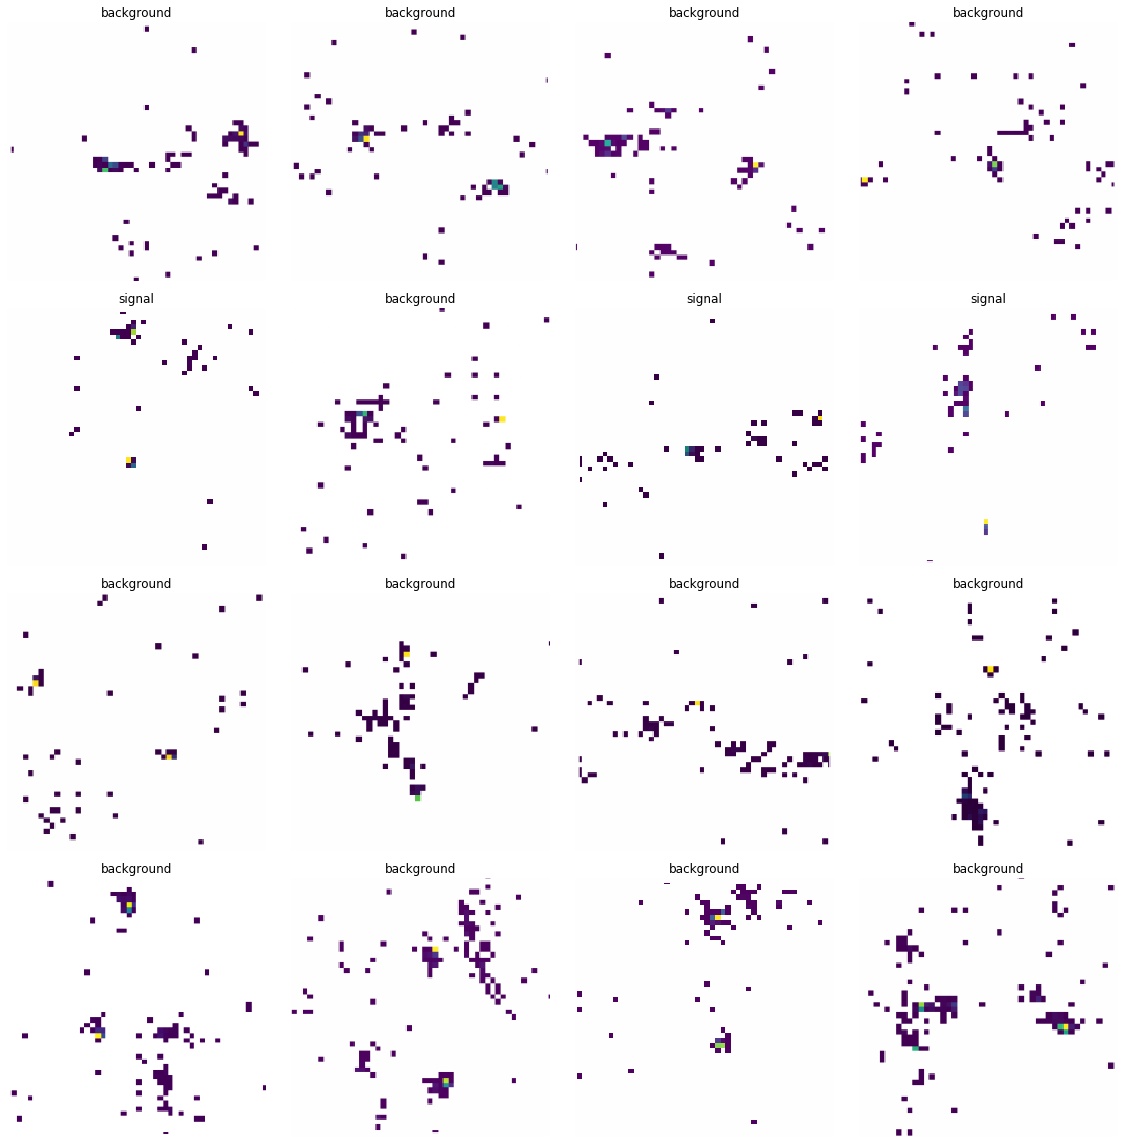

In [6]:
data.show_batch(4)

### The classes:

In [7]:
data.classes

['background', 'signal']

### and how many images we have for training and validation:

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['background', 'signal'], 2, 77808, 20142)

In [9]:
trn_count = np.bincount(data.train_ds.y)
val_count = np.bincount(data.valid_ds.y)

### also within each class:

In [10]:
for i in range(len(data.classes)):
    print('{} of images for {}'.format(trn_count[i], data.train_ds.classes[i]))

37397 of images for background
40411 of images for signal


## The fastai library includes several pretrained models from torchvision, namely:

- resnet18, resnet34, resnet50, resnet101, resnet152
- squeezenet1_0, squeezenet1_1
- densenet121, densenet169, densenet201, densenet161
- vgg16_bn, vgg19_bn
- alexnet

In [11]:
model = models.resnet18

### vision.learner is the module that defines the cnn_learner method, to easily get a model suitable for transfer learning.

In [12]:
learn = cnn_learner(data, model, pretrained=True, metrics=[accuracy,error_rate]).mixup(alpha=0.45)

## What is mixup?

This module contains the implementation of a data augmentation technique called mixup. It is extremely efficient at regularizing models in computer vision.

As the name kind of suggests, the authors of the mixup article propose training the model on mixes of the training set images. For example, suppose we’re training on CIFAR10. Instead of feeding the model the raw images, we take two images (not necessarily from the same class) and make a linear combination of them: in terms of tensors, we have:

new_image $= t * image1 + (1-t) * image2$

where t is a float between 0 and 1. The target we assign to that new image is the same combination of the original targets:

new_target $= t * target1 + (1-t) * target2$

assuming the targets are one-hot encoded (which isn’t the case in PyTorch usually). And it's as simple as that.

### The class below is created to scan over different values of weight decay to find the best hyperparameters for weight decay and learning rate:

In [13]:
@dataclass
class wd_finder:
    learn: Learner
    wd:Union[int,Callable] = None
    
    def __post_init__(self, **kwargs):
        self.wd_list = listify(self.wd)
        self.wd_recorder = []
        
        if self.wd is None:
            self.wd_list = [0,1e-1,1e-3,1e-5]
            
        for wd in self.wd_list:
            self.learn.lr_find(wd=self.wd,**kwargs)
            self.wd_recorder.append(self.learn.recorder)
            
    def plot_wd(self, skip_start:int=10, skip_end:int=5)->None:
        _, ax = plt.subplots(1,1)
        
        for k, i in enumerate(self.wd_recorder):
            losses = i.losses[skip_start:-skip_end] if skip_end > 0 else i.losses[skip_start:]
            lrs = i.lrs[skip_start:-skip_end] if skip_end > 0 else i.lrs[skip_start:]
            ax.plot(lrs, losses, label='WD={}'.format(self.wd_list[k]))
            ax.set_xlabel('Learning Rate')
            ax.set_ylabel('Loss')
            ax.legend()
            ax.set_xscale('log')

In [14]:
learn.to_fp16();

In [15]:
find_wd = wd_finder(learn)

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


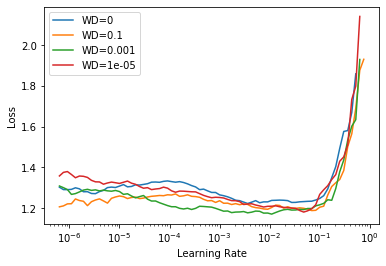

In [16]:
find_wd.plot_wd()

In [17]:
nb_epochs = 5

In [18]:
learn.fit_one_cycle(nb_epochs, max_lr=slice(1e-4,2e-2),wd=1e-3, 
                    callbacks=SaveModelCallback(learn, every='improvement',
                                                monitor='accuracy', 
                                                name='resnet_18_mixup_0d45'))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.550750,0.460016,0.784629,0.215371,08:48
1,0.514765,0.383826,0.831645,0.168355,02:43
2,0.486635,0.360455,0.844454,0.155546,02:44
3,0.471026,0.352291,0.849171,0.150829,02:43
4,0.466257,0.347951,0.850114,0.149886,02:39


Better model found at epoch 0 with accuracy value: 0.7846291065216064.
Better model found at epoch 1 with accuracy value: 0.8316453099250793.
Better model found at epoch 2 with accuracy value: 0.8444543480873108.
Better model found at epoch 3 with accuracy value: 0.8491708636283875.
Better model found at epoch 4 with accuracy value: 0.8501141667366028.


### 85% of accuracy with 5 epochs, not too shaby. to perform inference is reccomend to return the model to fp32:

In [19]:
learn.to_fp32();

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

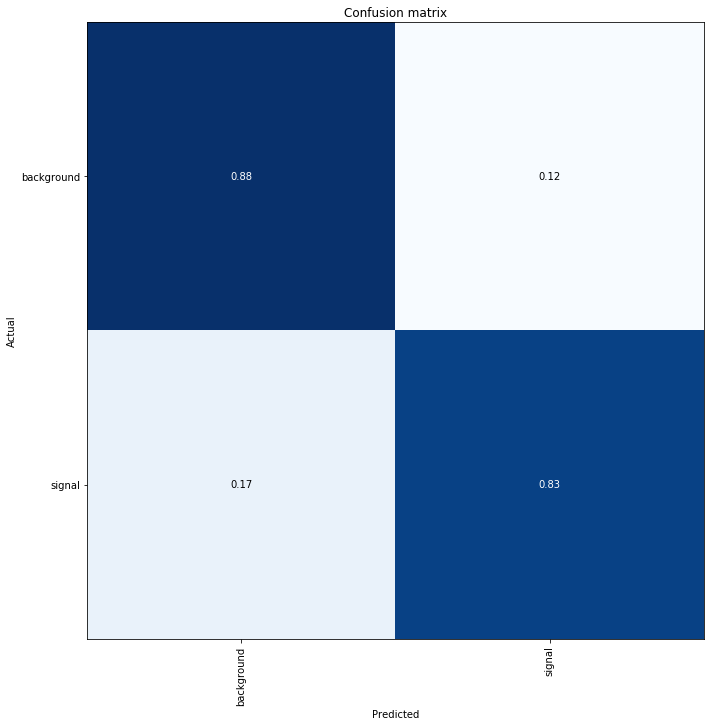

In [21]:
interp.plot_confusion_matrix(normalize=True,figsize=(10,10))

# experiments:

In [ ]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=0, sub=0, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak != 0 else F.relu(x)
        if self.sub != 0: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=1, zero_bn=False, act=True, bias=False, **kwargs):
        super().__init__()
        self.bn = nn.BatchNorm2d(nf)
        nn.init.constant_(self.bn.weight, 0. if zero_bn else 1.)
        self.conv = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)
        if act: 
            self.relu = GeneralRelu(**kwargs)
            
        self.act = act
    
    def forward(self, x): 
        out = (self.bn(self.conv(x)))
        if self.act: out = self.relu(out)
        return out
    
    def has_relu(self):
        return self.act
    
    @property
    def bias(self):
        return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight
    
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
def is_monitored_layer(l):
    mon_layers = (nn.Linear, ConvLayer)
    return isinstance(l, mon_layers)

class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1, **kwargs):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [ConvLayer(ni, nh, 3, stride=stride, **kwargs),
                   ConvLayer(nh, nf, 3, zero_bn=True, act=False, **kwargs)
        ] if expansion == 1 else [
                   ConvLayer(ni, nh, 1, **kwargs),
                   ConvLayer(nh, nh, 3, stride=stride, **kwargs),
                   ConvLayer(nh, nf, 1, zero_bn=True, act=False, **kwargs)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act=False, **kwargs)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act_fn = GeneralRelu(**kwargs)

    def forward(self, x): 

        return self.act_fn(self.convs(x) + self.idconv(self.pool(x)))
    

class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=10, **kwargs):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [ConvLayer(nfs[i], nfs[i+1], stride=2 if i==0 else 1, **kwargs)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2, **kwargs)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        #init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride, **kwargs):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, **kwargs)
              for i in range(n_blocks)])
    
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)

In [ ]:
def init_cnn(m, leak=0):
    if not isinstance(m, ConvLayer) and getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight, a=leak)
    for l in m.children(): init_cnn(l)

In [ ]:
def init_cnn_uniform(m, leak=0):
    if not isinstance(m, ConvLayer) and getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_uniform_(m.weight, a=leak)
    for l in m.children(): init_cnn(l)

In [ ]:
model = models.resnet18

In [ ]:
learn = cnn_learner(data, model, pretrained=False, metrics=[accuracy,error_rate]).mixup()

In [ ]:
init_cnn_uniform(learn.model, leak=0)

In [ ]:
learn.unfreeze();

In [ ]:
learn.to_fp16();

In [ ]:
find_wd = wd_finder(learn)

In [ ]:
find_wd.plot_wd()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,2e-2),wd=1e-1, 
                    callbacks=SaveModelCallback(learn, every='improvement',
                                                monitor='accuracy', 
                                                name='resnet_18_kaiming_uniform_0'))

In [ ]:
learn.to_fp32();

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(normalize=True,figsize=(10,10))
plt.savefig('CM_resnet_18.png')